In [1]:
from util.util import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
input_path = 'input/'
os.listdir(input_path)

['train.csv', 'sample_submission.csv', 'test_images', 'train_images']

In [3]:
train_df = pd.read_csv(os.path.join(input_path,'train.csv'))
sub_df = pd.read_csv(os.path.join(input_path,'sample_submission.csv'))
train_df.head(4)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN


In [4]:
sub_df.head(4)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1


In [5]:
def add_features(df):
    df['img_id'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
    df['img_label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])
    df['is_encoded_pixls_null'] = df['EncodedPixels'].isnull()
    return df
train_df = add_features(train_df)
sub_df = add_features(sub_df)
train_df.head(4)

,Image_Label,EncodedPixels,img_id,img_label,is_encoded_pixls_null
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,False
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,False
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,True
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,True


In [6]:
print(train_df.loc[train_df['is_encoded_pixls_null'] == False,'img_id'].count())
print(train_df.loc[train_df['is_encoded_pixls_null'] == True,'img_id'].count())

11836
10348


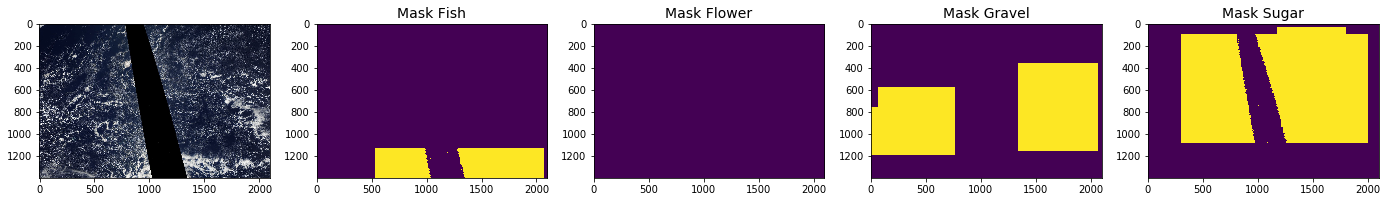

In [7]:
img_name = train_df['img_id'][110]
mask = make_mask(train_df,img_name)
img = get_img(img_name,'input/train_images/')
visualize(img,mask)

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
pdf =  PdfPages('plots/augumentation.pdf')
for augment in [albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5),
                      albu.GridDistortion(p=1),
                      albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                      albu.RandomRotate90(p=1),
                      albu.VerticalFlip(p=1),
                      albu.HorizontalFlip(p=1),]:
    plot_with_augmentation(img,mask,augment=augment)
    pdf.savefig()
    plt.close()
pdf.close()

In [9]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{input_path}/train_images"
        else:
            self.data_folder = f"{input_path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [10]:
train_ids = train_df['img_id'].drop_duplicates().values
print(len(train_ids))
train_ids, val_ids = train_test_split(train_ids,test_size=0.33,random_state=10)
print(len(train_ids),len(val_ids))

5546
3715 1831


In [11]:
test_ids = sub_df['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values
print(len(test_ids))
test_ids

3698


array(['002f507.jpg', '0035ae9.jpg', '0038327.jpg', ..., 'ffcf5b0.jpg',
       'ffe0620.jpg', 'fff3c5c.jpg'], dtype=object)

## build a unet model

In [12]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

BATCH_SIZE = 2
train_set = CloudDataset(df=train_df, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
val_set = CloudDataset(df=train_df, datatype='valid', img_ids=val_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)

/home/harrison/anaconda3/envs/kaggle/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [13]:
num_epochs = 101
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

In [ ]:
loaders = {
    "train": train_loader,
    "valid": val_loader
}
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/101 * Epoch (train): 100% 1858/1858 [08:16<00:00,  3.74it/s, _timers/_fps=1.748, dice=0.480, loss=0.814] 
0/101 * Epoch (valid): 100% 916/916 [02:23<00:00,  6.39it/s, _timers/_fps=29.515, dice=0.560, loss=0.797]
[2019-08-31 19:25:23,772] 
0/101 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=9.5145 | _timers/batch_time=0.2176 | _timers/data_time=0.2104 | _timers/model_time=0.0071 | dice=0.2984 | loss=1.0875
0/101 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=15.9149 | _timers/batch_time=0.1267 | _timers/data_time=0.1222 | _timers/model_time=0.0045 | dice=0.3551 | loss=1.1143
1/101 * Epoch (train): 100% 1858/1858 [08:17<00:00,  3.74it/s, _timers/_fps=19.602, dice=0.424, loss=0.861]
1/101 * Epoch (valid): 100% 916/916 [02:28<00:00,  6.15it/s, _timers/_fps=30.309, dice=0.553, loss=0.725]
[2019-08-31 19:36:10,869] 
1/101 * Epoch 1 (train): _base/lr=0.0100 | _base/momentum=0.9000 | _timers/_fps=9.3959 | _timers/batch_time=0.2189 | _tim

In [ ]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

## take a peek at valid set

In [ ]:
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)
valid_masks = []
probabilities = np.zeros((2220, 350, 525),dtype=np.float32)
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[1].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

In [ ]:
attempts = []
for t in tqdm.tqdm(range(0, 100, 5)):
    t /= 100
    for ms in [0, 1000, 10000, 15000, 20000, 25000]:
        masks = []
        for probability in probabilities:
            predict, num_predict = post_process(sigmoid(probability), t, ms)
            masks.append(predict)

        d = []
        for i, j in zip(masks, valid_masks):
            if i.sum() != 0:
                d.append(dice(i, j))

        attempts.append((t, ms, np.mean(d)))
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

In [ ]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice');
plt.show()

best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

In [ ]:
for i, (input, output) in enumerate(zip(
        valid_dataset, runner.callbacks[1].predictions["logits"])):
    image, mask = input
        
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = (sigmoid(output) > best_threshold).astype('uint8').transpose(1, 2, 0)
        
    visualize_with_raw(image=image_vis, mask=pr_mask, original_image=image_vis, original_mask=mask, raw_image=image_vis, raw_mask=output.transpose(1, 2, 0))
    
    if i >= 2:
        break

## predicting

In [22]:
test_set = CloudDataset(df=sub_df, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

loaders = {"test": test_loader}

/home/harrison/.conda/envs/kaggle/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [26]:
encoded_pixels = []
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:
            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), best_threshold, best_size)
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)


 16%|█▋        | 303/1849 [01:00<04:58,  5.18it/s]


 25%|██▍       | 455/1849 [01:31<04:32,  5.11it/s]/home/harrison/codebase/python/kaggle/understanding-clouds/util/util.py:152: RuntimeWarning:

overflow encountered in exp


 33%|███▎      | 603/1849 [02:00<03:56,  5.26it/s]


 49%|████▉     | 905/1849 [03:00<03:01,  5.19it/s]


 65%|██████▌   | 1203/1849 [03:59<02:04,  5.20it/s]


 81%|████████  | 1499/1849 [04:57<01:09,  5.02it/s]


 97%|█████████▋| 1795/1849 [05:56<00:10,  5.24it/s]


100%|██████████| 1849/1849 [06:07<00:00,  5.08it/s]

In [27]:
sub_df['EncodedPixels'] = encoded_pixels
sub_df.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [31]:
sub_df.drop(['img_id','img_label','is_encoded_pixls_null'],axis=1)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 183750
1,002f507.jpg_Flower,1 183750
2,002f507.jpg_Gravel,1 183750
3,002f507.jpg_Sugar,1 183750
4,0035ae9.jpg_Fish,1 183750
5,0035ae9.jpg_Flower,1 183750
6,0035ae9.jpg_Gravel,1 183750
7,0035ae9.jpg_Sugar,1 183750
8,0038327.jpg_Fish,1 183750
9,0038327.jpg_Flower,1 183750
